In [183]:
from utils import *
from collision import *

%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# notes from class

The cell below demonstrates many ways of running our environments with multiple particles

<IPython.core.display.Javascript object>


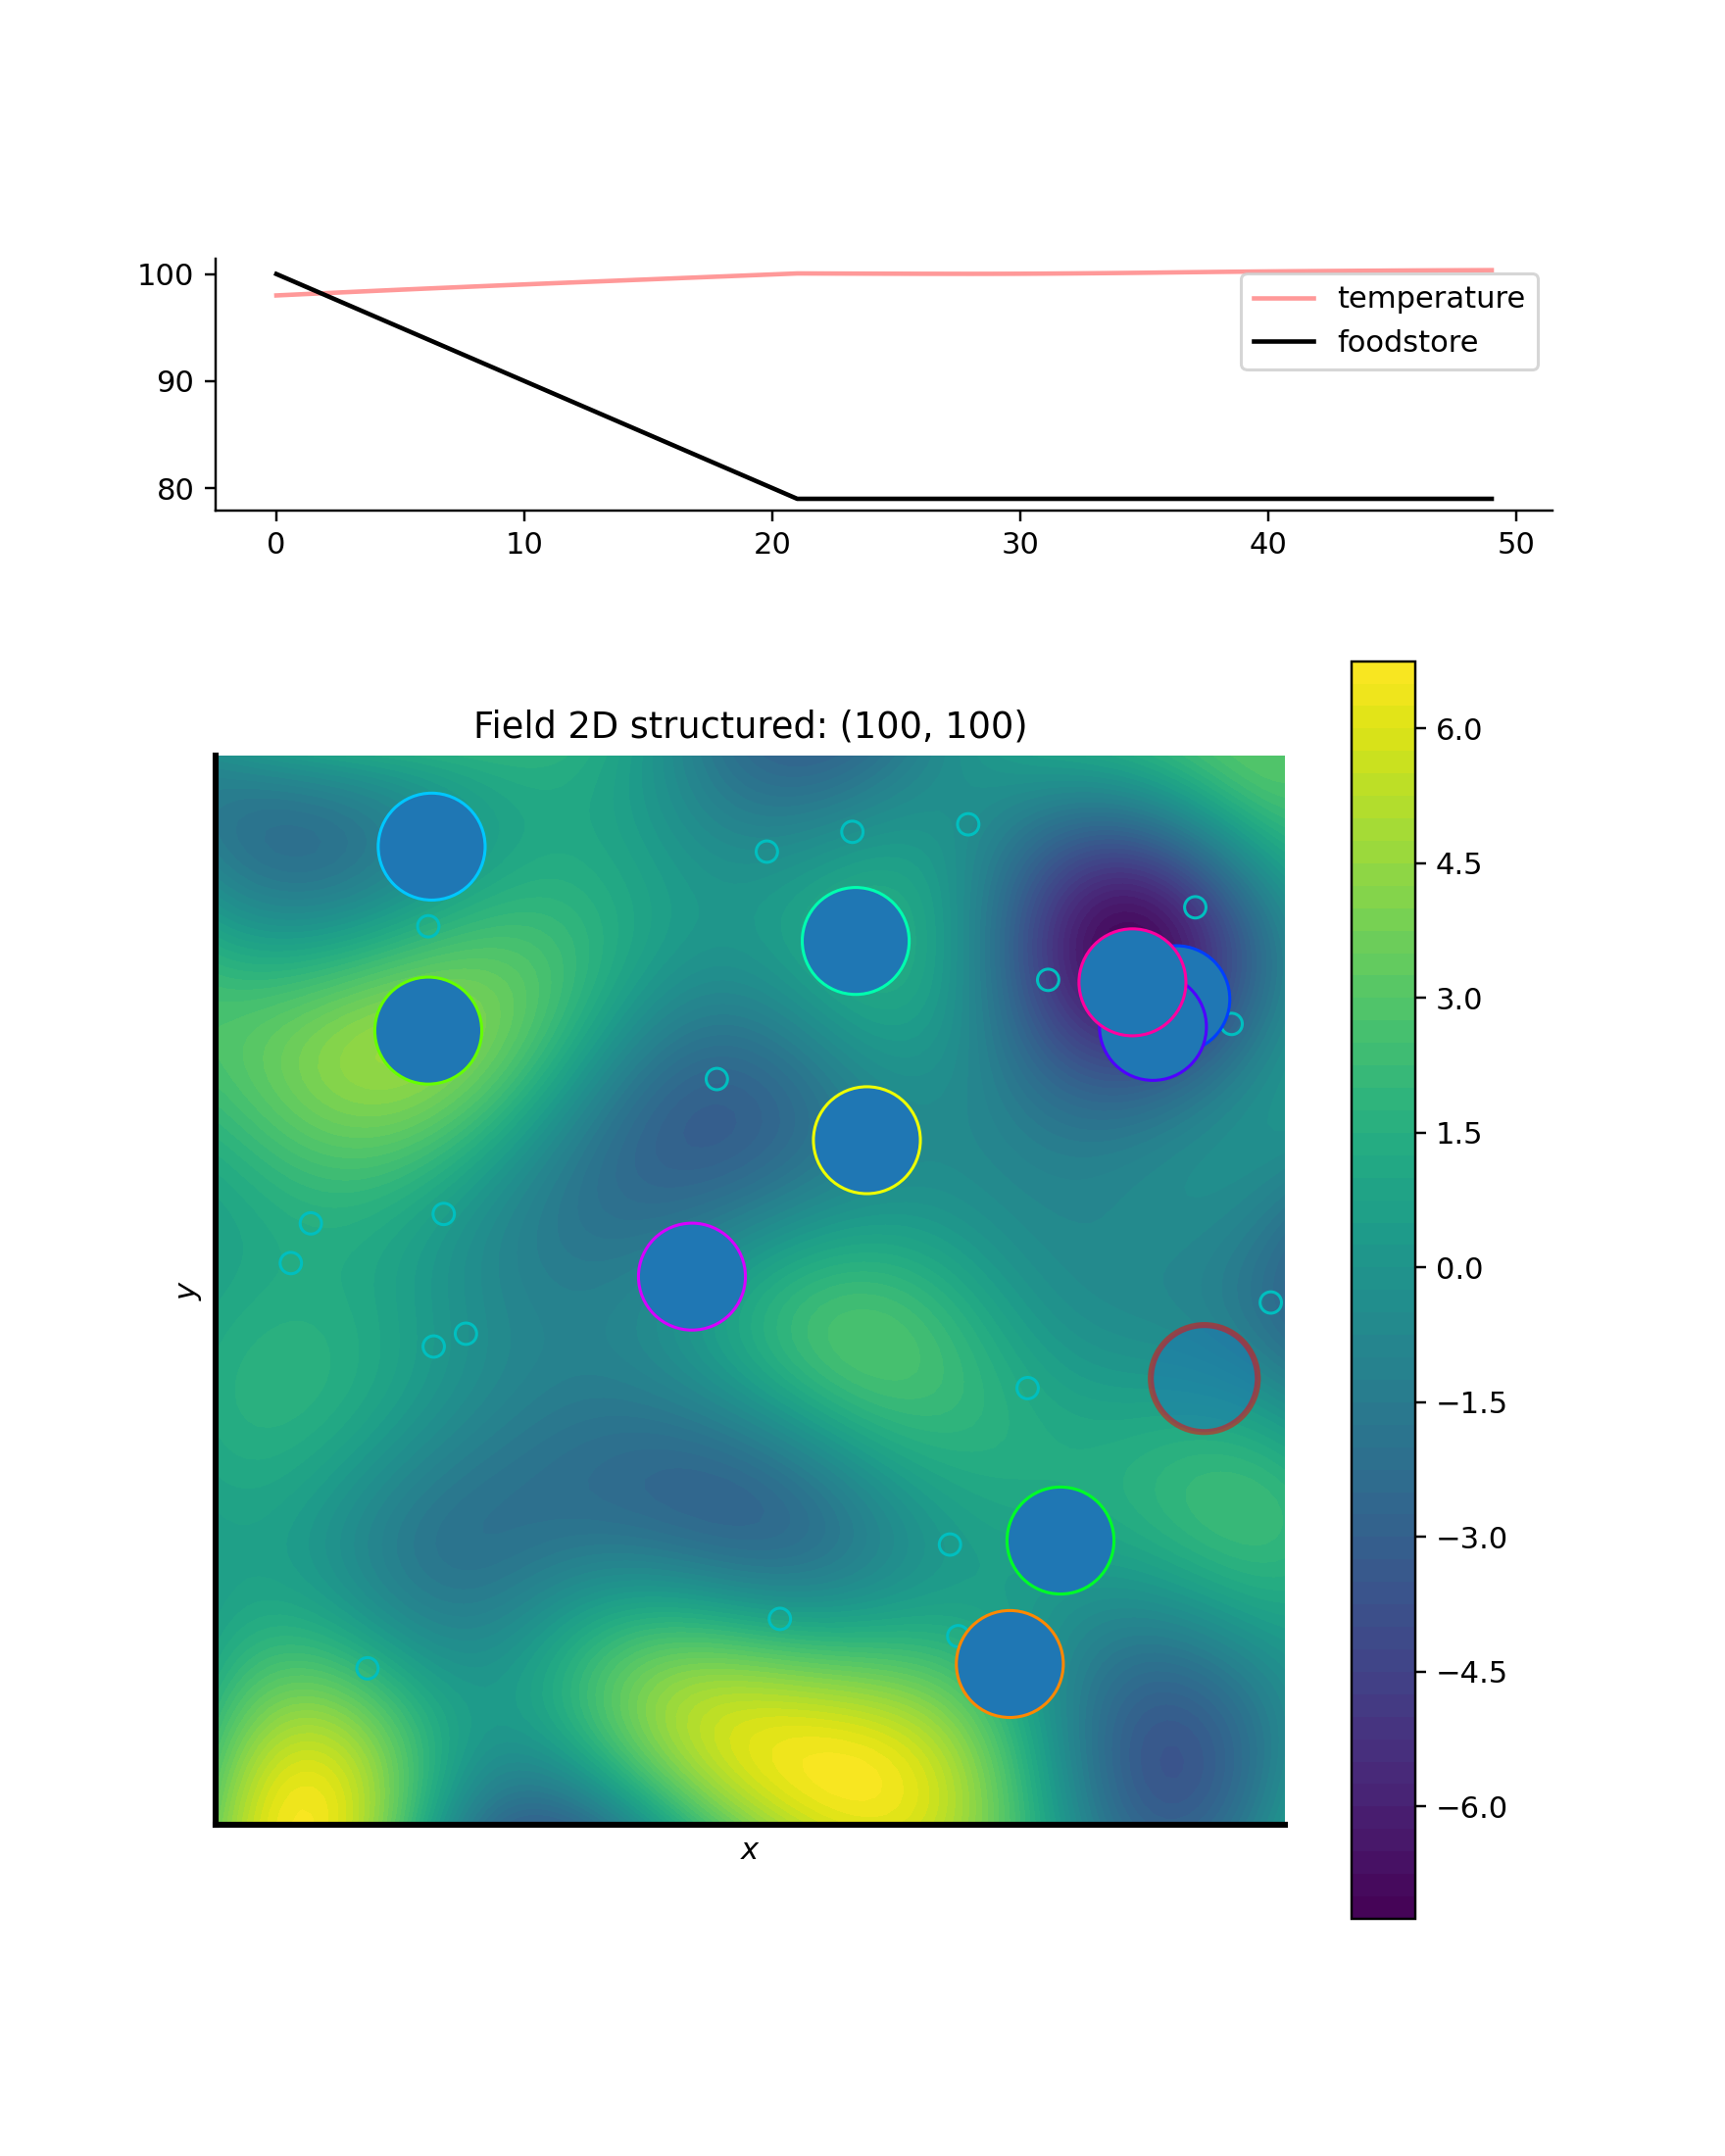

In [131]:
nparticles = 20
#generate an environment with 20 particles
sim = hw1_environment(nparticles)


#add a fancy particle
p = homeostasis_agent()
sim.particles.insert(0, p)



#add a lot of fancy particles!
col = sns.color_palette("hsv", 10)
ps = [homeostasis_agent(styles = {'edgecolor': col[i]}) for i in range(10)]

#particles is just a list, you can slice and dice it 
sim.particles = sim.particles + ps


sim.do_animation(save=False)

# outline of the overall lifecycle of a particle and the environment

In class we talked about simplifying the code from the previous HW and class. We updated the code to follow the below logic, and in particular we removed any control the particle had over it's own velocity, so we could really understand how the environemnt contributes to the particles velocity. In this hw, we will see how the particle can take back control, and hopefully live a longer life! The following code blocks define the agent and the environment, as in class.


while a particle exists:
    for each particle:
        -> advance particle
            exist logging
            monitor 
            move  
        
        -> interact
            -> update particles (temperature)
            -> update particles (velocity)
            
    -> bounce all the particles off the walls 
            

In [140]:
class motor_agent(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x = .5, y = .5, vx = 0, vy=0, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5} , food_store = 100):
        self.r = np.array((x, y)).astype('float32')
        self.v = np.array((vx, vy)).astype('float32')
        self.radius = radius
        self.mass = self.radius**2
        self.delete = False
        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'c', 'fill': False}
        self.food_store = food_store
        self.temperature = 98; 
        self.set_point = 98 #homeostatic temp
        self.margin =  .5
        self.last_temp = 98
        self.last_vel = np.array((vx, vy)).astype('float32')
        
        self.temp_log = []
        self.food_log = []
        self.grad_log = []
    
    def homeostasis_monitor(self):
        return self.temperature - self.set_point
    
    def temp_change_monitor(self):
        return self.temperature - self.last_temp
    
    
    def consume(self, dt):
    
        self.food_store -= 1;
        self.temperature += .1
         
    def move(self, dt):
        self.r += self.v * dt
        
            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        #check internal state

        
        self.move(dt)
        self.exist(dt)
            
    def exist(self, dt):
        
        self.grad_log.append(np.sign(self.v[0]))
        
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)
        self.last_temp = self.temperature
        self.last_vel = self.v
        #this means we're dead!
        if self.food_store < 0:
            self.delete = True
        if self.temperature < 90 or self.temperature > 105:
            self.delete = True
            

In [141]:
class motor_environment(Simulation):
    #this is our interaction! The environment changes temperature and motion of the particle
    def update_velocity(self, p, x_ind, y_ind):
        if len(self.srf["field"].shape) > 2:
            vx = .02*self.srf["field"][0, x_ind, y_ind]
            vy = .02*self.srf["field"][1, x_ind, y_ind]
            
            p.vx, p.vy = p.vx + vx, p.vy + vy
            
        elif len(self.srf["field"].shape) == 2:
            if self.srf.field[x_ind, y_ind] > 0:
                p.v = p.v #+ .15self.srf.field[x_ind, y_ind]*self.dt
            if self.srf.field[x_ind, y_ind] < 0:
                p.v = .9*p.v #+ .01*self.srf.field[x_ind, y_ind]*self.dt    
        else:
            pass

            
        
    def update_temperature(self, p, x_ind, y_ind):
        if hasattr(p, 'temperature'): 

            if len(sim.srf.field.shape) > 2:
                p.temperature = p.temperature + (np.hypot(*self.srf.field[:, x_ind, y_ind]) - 2.0) 

            elif len(self.srf["field"].shape) == 2:

                    p.temperature = p.temperature + self.srf.field[x_ind, y_ind]*(self.dt) 

    
    def interact(self, p):
            #bounce the particle off the walls
            self.handle_boundary_collisions(p)
            
            #change the temperature of the agent
            x_ind, y_ind = self.get_grid_inds(p)
            
            self.update_velocity(p, x_ind, y_ind)
            #move faster in high temp regions
            
            self.update_temperature(p, x_ind, y_ind)

                
           # p.v = .95*p.v
        
    def animate(self, i):
        """The function passed to Matplotlib's FuncAnimation routine."""
        self.ri_ax.cla() # clear the previous image
        self.ri_ax.patch.set_alpha(0.5)
        
        self.ri_ax.plot(np.array(self.particles[0].temp_log) + 0, alpha = .4, c = 'r', label = 'temperature')# plot the line
        self.ri_ax.plot(np.array(self.particles[0].grad_log) + 98,  c = 'k', label = 'X velocity')
        self.ri_ax.legend()
        sns.despine(ax = self.ri_ax)
        self.advance_animation()
        return self.circles
                
    def advance(self):
        """Advance the animation by dt."""
        for i, p in enumerate(self.particles):
            if p.delete:
                self.particles.remove(p)
                self.n -=1
            else:
                p.advance(self.dt)
                self.interact(p)
        
        self.handle_collisions()

# A basic simulation

In the cells below, we can watch the particle move through it's environment, while ploting it's temperature, and the sign of it's 'x' velocity. This means we can see if/when the particle changes direction. It's 'x' velocity is just the component of it's velocity in the x direction. 

I also modified the code such that SRF is always the same for a particular scale, please do not change the scale for this homework assignment. In fact, you never have to redefine SRF after this cell. This will mean that the runs of your simulations always produce comparable results!

In [148]:
srf = generate_tempgrad(scale = .15)

sim = motor_environment(n = 0, srf = srf)
p = motor_agent(vx = .5, vy = .5)

sim.particles.insert(0, p)

In [149]:
sim.advance()

<IPython.core.display.Javascript object>


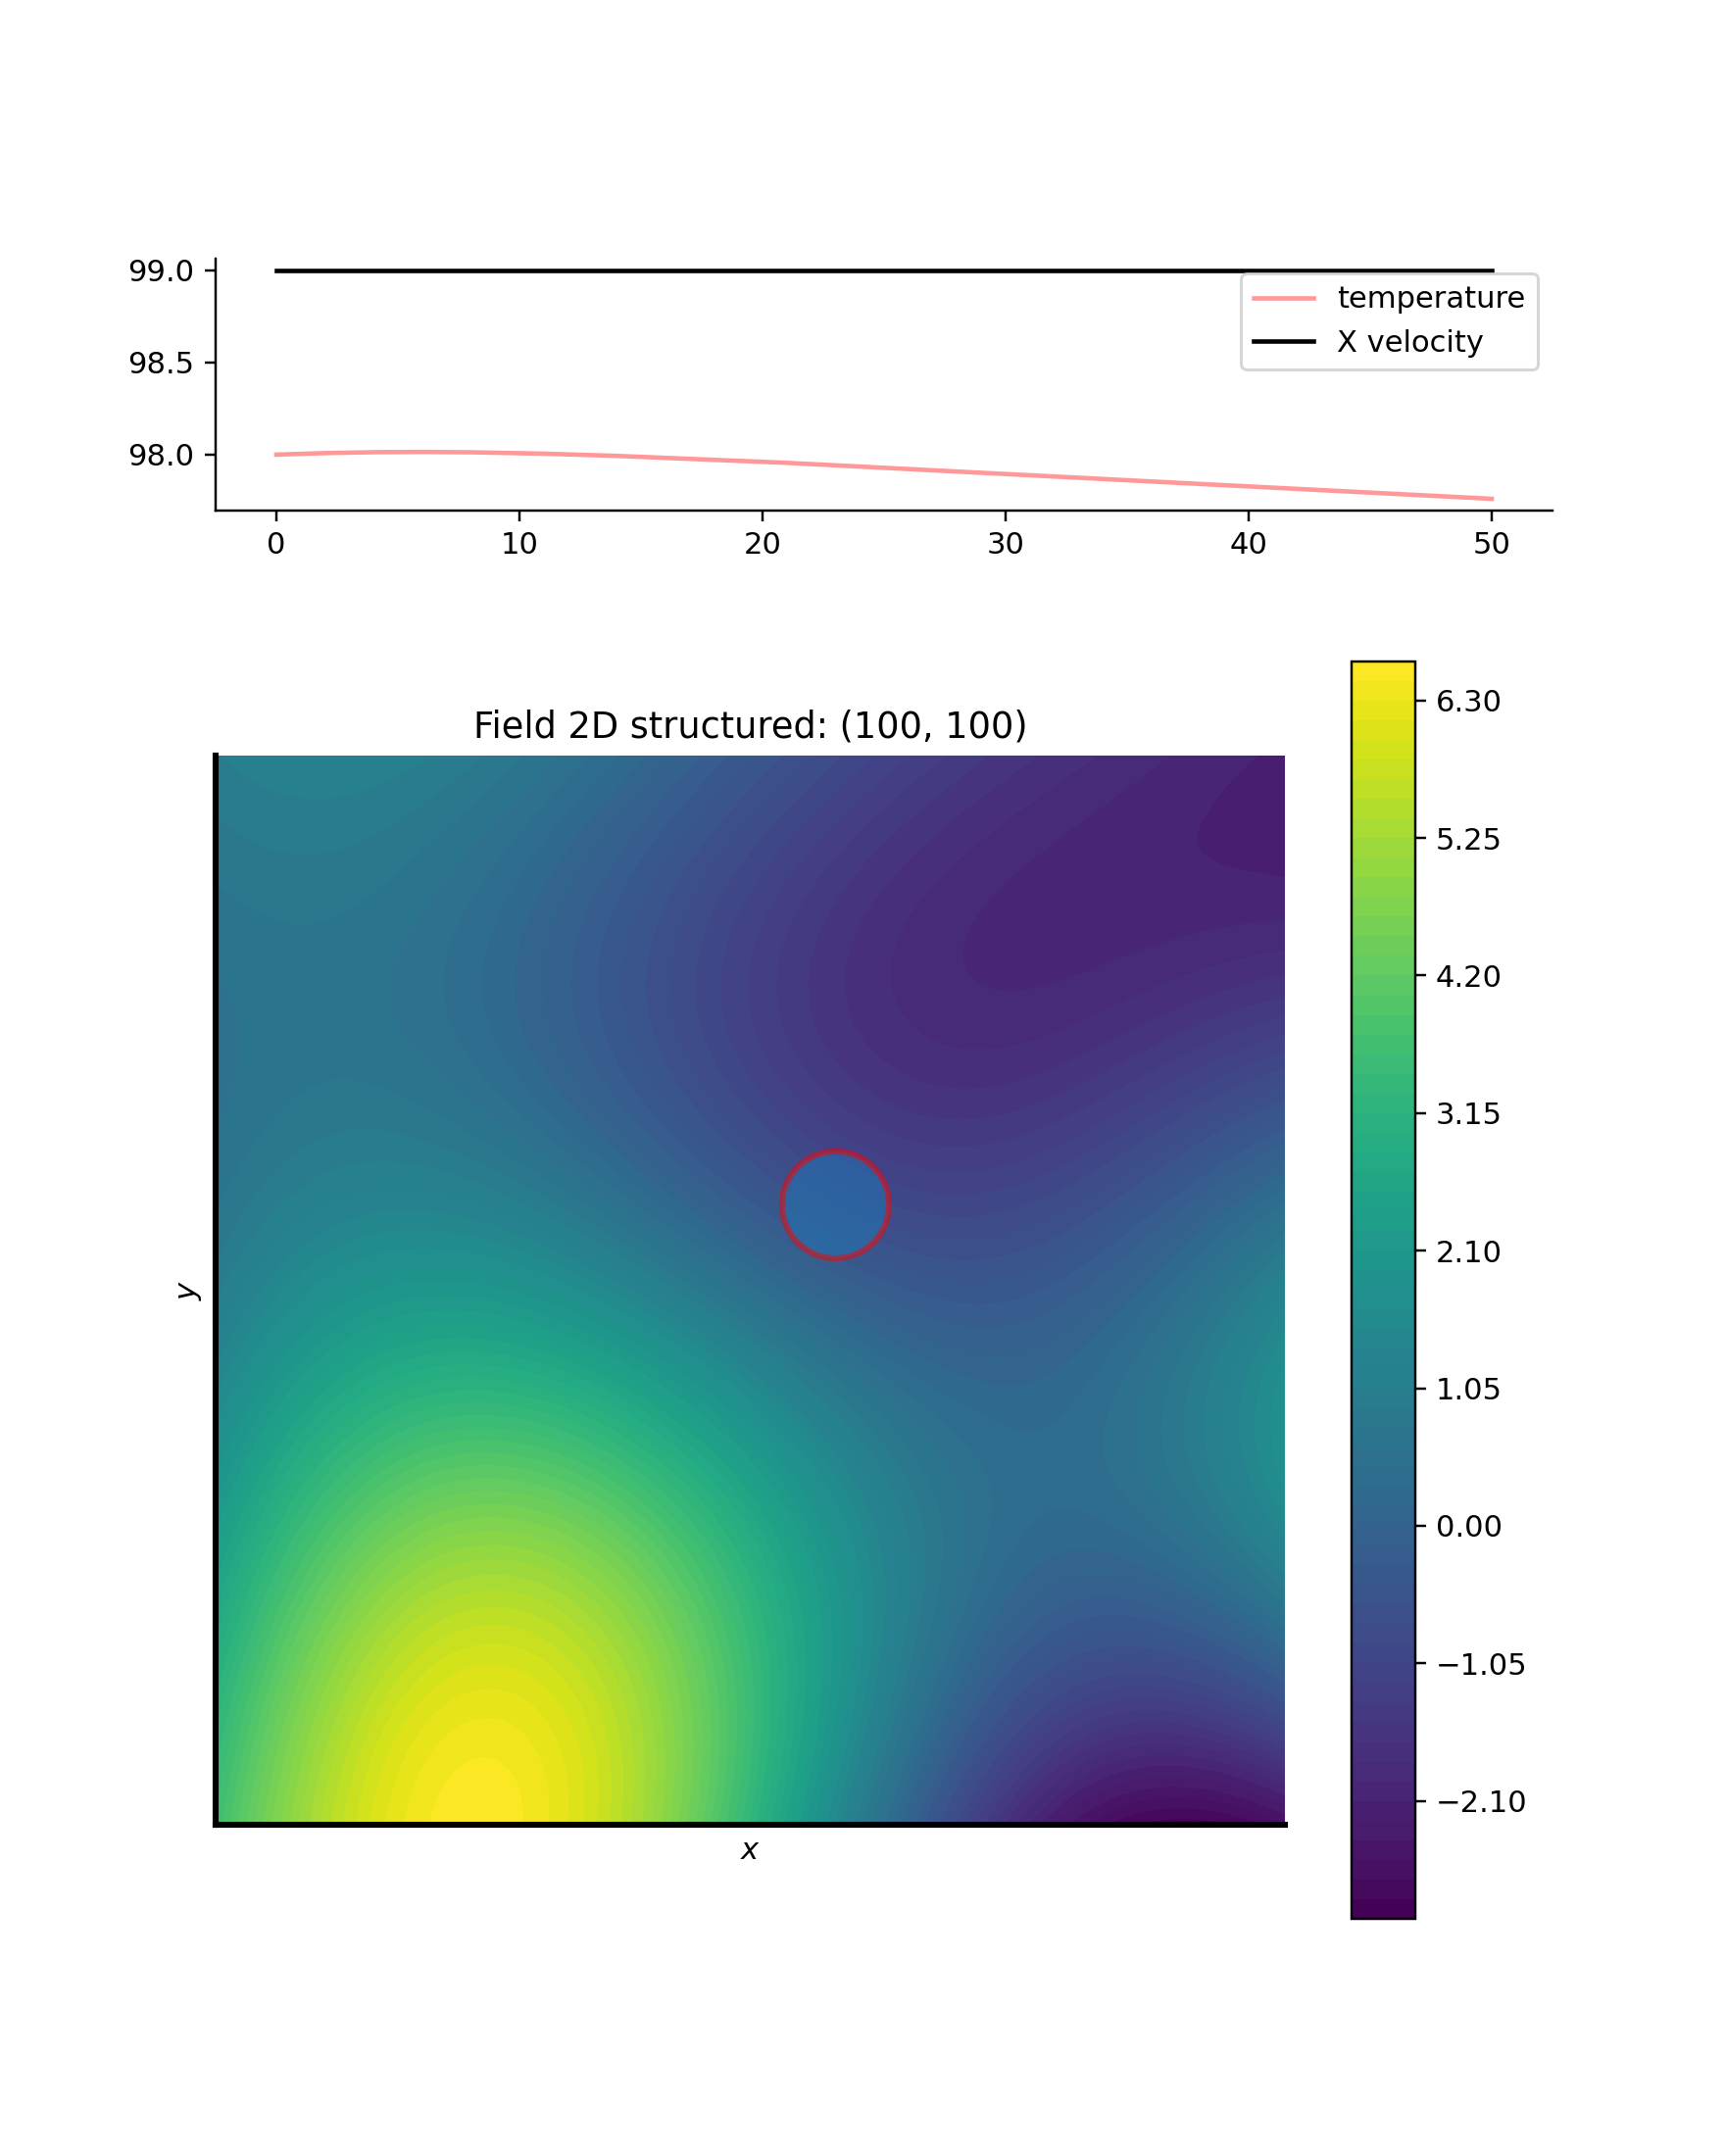

In [150]:
%matplotlib notebook

sim.do_animation()

# HW 2 Question 1a 2pts

You may remember it sometimes being very slow to run simulations. This can happen when the particle gets "stuck" in a happy spot where it's temperature is in equilibrium, and it never has to move! Please modify the life_times simulation in the spot indicated below, such that the while loop runs for a maximum lifetime length of 500. That is, i*sim.dt should never get larger than 500.

# HW 2 Question 1a 2pts

Now that we are always using the same environment, we have to find a new way to introduce variability, in order to determine the fitness of our particle. Modify the constuctor for the motor agent code in the spot listed below, to initialize the x and y position of the particle within the simulation. The boundaries of the simulation are (0, 1) for both X and Y, but you should initialize the particle slightly away from the walls, so it doesnt get stuck. That is, the initial position of the particle should be between x $\in$ [.1, .9], y $\in$ [.1, .9]

In [161]:
life_times = []

n_particles = 0
for i in range(100):
    sim = motor_environment(n_particles, [],  srf = srf)
    
    #your code for 1b goes in the constructor below
    p = motor_agent(x = , y =  , vx = .5, vy = .5)
    
    #add our particle to the simulation  
    sim.particles.insert(0, p)

    i = 0;
    while ():#your code for 1a goes within the parentheses to the left# 
        sim.advance()
        i+=1;
        
    life_times.append(i*sim.dt)

# HW 2 Question 1b 1pt
Plot the distribution of particle lifespans

Text(14.04, 0.015, 'the average lifetime is :14.04')

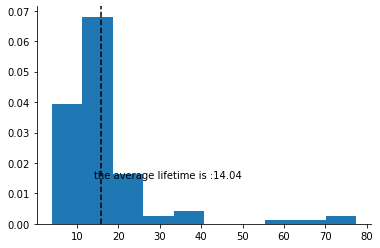

In [162]:
%matplotlib inline

plt.hist(life_times, density = True)
sns.despine()
plt.axvline(np.mean(life_times), color = 'k', linestyle = '--')
plt.annotate("the average lifetime is :" + str(np.median(life_times).round(2)), [np.median(life_times).round(2), .015])

# HW 2 Question 2

In the second homework question we will let the agent decide which direction to move. I started you off by recreating the motor_agent class below. 

# 1a 2 pts

Add a function to the motor_agent1 class to set the particles velocity. The function should be named "update_v", and should take a single argument, the new velocity. This function has no return value, and simply sets the particles velocity to whatever is input to the function. 

# 1b 10 pts

Add logic to the "advance" function, to update the particles position as a function of the variables "d_temp", and "temp_change", defined in the code. These variables measure the particles temperature with respect to it's temperature in the previous timestep, and it's temperature with respect to it's set point. You may also access the particles velocity. This question is a bit tricky, and I expect you'll have to play around with a few different ideas, before you find one that works. You should be able to increase the particles average lifespan by a minimum of ~1.5x. Please plot the average lifespan histogram, and write a small paragraph describing the logic of your solution. 

In [186]:
class motor_agent1(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x = .5, y = .5, vx = 0, vy=0, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5} , food_store = 100):
        self.r = np.array((x, y)).astype('float32')
        self.v = np.array((vx, vy)).astype('float32')
        self.radius = radius
        self.mass = self.radius**2
        self.delete = False
        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'c', 'fill': False}
        self.food_store = food_store
        self.temperature = 98; 
        self.set_point = 98 #homeostatic temp
        self.margin = .5
        self.last_temp = 98
        self.last_vel = np.array((vx, vy)).astype('float32')
        
        self.temp_log = []
        self.food_log = []
        self.grad_log = []
    
    def homeostasis_monitor(self):
        return self.temperature - self.set_point
    
    def temp_change_monitor(self):
        return self.temperature - self.last_temp
  
         
    def move(self, dt):
        self.r += self.v * dt
       
    #your code goes here
    def #new function#
        
            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        

        d_temp = self.homeostasis_monitor()  
        temp_change = self.temp_change_monitor()
        
        
        if abs(d_temp) > self.margin:
            #your code goes here

        
        self.move(dt)
        self.exist(dt)
            
    def exist(self, dt):

        self.grad_log.append(np.sign(self.v[0]))
        
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)
        self.last_temp = self.temperature
        self.last_vel = self.v
        #this means we're dead!
        if self.food_store < 0:
            self.delete = True
        if self.temperature < 90 or self.temperature > 105:
            self.delete = True
            

            

SyntaxError: invalid syntax (2770002433.py, line 35)

In [180]:
#define the new agent and environemnt

In [185]:
#run an animation to watch the simulation!

In [171]:
#re run the simulation 100x

In [184]:
#plot the histogram